In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 9,  5,  6,  8, 10,  3,  7,  0,  1]), tensor([2, 4]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [5]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # <1>
linear_model(t_un_val)

tensor([[2.3737],
        [2.3186]], grad_fn=<AddmmBackward>)

In [6]:
linear_model.weight

Parameter containing:
tensor([[0.2898]], requires_grad=True)

In [7]:
linear_model.bias

Parameter containing:
tensor([0.6868], requires_grad=True)

In [8]:
x = torch.ones(1)
linear_model(x)

tensor([0.9767], grad_fn=<AddBackward0>)

In [9]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[0.9767],
        [0.9767],
        [0.9767],
        [0.9767],
        [0.9767],
        [0.9767],
        [0.9767],
        [0.9767],
        [0.9767],
        [0.9767]], grad_fn=<AddmmBackward>)

In [10]:
linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(
    linear_model.parameters(), # <2>
    lr=1e-2)

In [11]:
linear_model.parameters()

<generator object Module.parameters at 0x0000021E61800D00>

In [12]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[-0.4267]], requires_grad=True), Parameter containing:
 tensor([-0.3609], requires_grad=True)]

In [13]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val, t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_un_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_un_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print('Epoch {}, Training loss {}, Validation loss {}'.format(
                epoch, float(loss_train), float(loss_val)))


In [14]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 163.3249969482422, Validation loss 143.2545166015625
Epoch 1000, Training loss 3.5493104457855225, Validation loss 2.5740952491760254
Epoch 2000, Training loss 3.043435573577881, Validation loss 2.5045695304870605
Epoch 3000, Training loss 3.0354838371276855, Validation loss 2.4961042404174805

Parameter containing:
tensor([[5.3719]], requires_grad=True)
Parameter containing:
tensor([-17.2279], requires_grad=True)


In [15]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 120.08021545410156, Validation loss 91.20027160644531
Epoch 1000, Training loss 3.6067957878112793, Validation loss 2.5785422325134277
Epoch 2000, Training loss 3.044339895248413, Validation loss 2.505098342895508
Epoch 3000, Training loss 3.0355000495910645, Validation loss 2.496168851852417

Parameter containing:
tensor([[5.3716]], requires_grad=True)
Parameter containing:
tensor([-17.2260], requires_grad=True)


In [16]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # <1>
            nn.Tanh(),
            nn.Linear(13, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [17]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [18]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [19]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [20]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [21]:
seq_model.output_linear.bias

Parameter containing:
tensor([-0.1145], requires_grad=True)

In [22]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 211.8280487060547, Validation loss 199.49093627929688
Epoch 1000, Training loss 4.598171234130859, Validation loss 2.401190757751465
Epoch 2000, Training loss 2.3254079818725586, Validation loss 1.8367892503738403
Epoch 3000, Training loss 2.1609959602355957, Validation loss 2.056598663330078
Epoch 4000, Training loss 1.9803590774536133, Validation loss 1.797584891319275
Epoch 5000, Training loss 1.8485851287841797, Validation loss 1.7419904470443726
output tensor([[12.9443],
        [11.6452]], grad_fn=<AddmmBackward>)
answer tensor([[15.],
        [11.]])
hidden tensor([[ 2.1954],
        [-9.8279],
        [10.1402],
        [-0.4411],
        [-0.0137],
        [-0.8646],
        [ 0.8701],
        [-9.2311]])


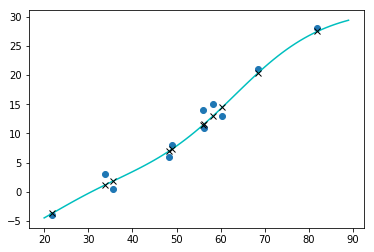

In [23]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


Epoch 1, Training loss 193.87867736816406, Validation loss 177.41183471679688
Epoch 1000, Training loss 63.839393615722656, Validation loss 9.437588691711426
Epoch 2000, Training loss 39.39881896972656, Validation loss 4.755532741546631
Epoch 3000, Training loss 21.22974967956543, Validation loss 3.001725435256958
Epoch 4000, Training loss 11.686051368713379, Validation loss 2.6802778244018555
Epoch 5000, Training loss 7.484605312347412, Validation loss 2.7541558742523193


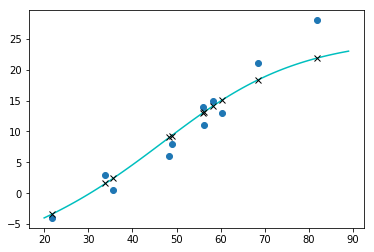

In [24]:
# Exercises here!

neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
